<a href="https://colab.research.google.com/github/cyw320712/ai_project/blob/master/team_project/Meeting_Daily_Classifier_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoBERT finetuning

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install torchmetrics

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-n68w__4l
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-n68w__4l
     |████████████████████████████████| 132 kB 3.9 MB/s 
     |████████████████████████████████| 344 kB 33.6 MB/s 
     |████████████████████████████████| 47.3 MB 132 kB/s 
     |████████████████████████████████| 4.5 MB 33.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.6 MB/s 
     |████████████████████████████████| 4.0 MB 33.4 MB/s 
     |████████████████████████████████| 6.6 MB 24.6 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 77 kB 3.6 MB/s 
     |████████████████████████████████| 880 kB 38.3 MB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 8.7 MB 28.3 MB/s 
     |████████████████████████████████| 127 kB 38.2 MB/s 
  Created wheel for kobert: filename=kob

# Import packages

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
from torchmetrics import F1Score
from sklearn.model_selection import KFold
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
## CPU
#device = torch.device("cpu")

## GPU
device = torch.device("cuda:0")

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May  7 06:27:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fix Seed 
For reproductibility, fix seed

In [ ]:
# Seed everything for reproductibility
def seed_everything(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
SEED = 2022
seed_everything(SEED)

# Dataset


In [ ]:
import pandas as pd
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/MyDrive/total_data.csv'

#pandas read_csv로 불러오기
data = pd.read_csv(filename, names=['ID', "data", "label"], encoding='cp949', header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# 불필요한 row, column 제거
data = data.drop(['ID'], axis=1)
data = data.drop([0], axis=0)

In [ ]:
# Get 30% random rows (이번 주는 소량 데이터로 학습)
data = data.sample(frac=0.1)
data.head()

,data,label
3624436,나이가 들수록 무릎이 아파,0
3935803,오해는 무슨 오해 흐유으으,0
646569,아 감기에 걸려서 입맛이 없네,0
2798195,우리 역시 이 시련과 역경 지금 있는 상황이 너무 어렵고 문법 너무 힘들다고 하더라...,0
3096269,코로나로 하루 종일 뉴스만 봐,0


In [ ]:
data.to_csv("/content/drive/MyDrive/small_data.csv", sep=",", index=False, encoding='euc-kr')

In [ ]:
print("전체 데이터 개수")
print("Label 0: ", data[data.label==0].shape[0])
print("Label 1: ", data[data.label==1].shape[0])

전체 데이터 개수
Label 0:  241091
Label 1:  148776


In [ ]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data, test_size=0.2)

In [ ]:
print("Train Dataset 데이터 개수")
print("Train - Label 0: ", dataset_train[dataset_train.label==0].shape[0])
print("Train - Label 1: ", dataset_train[dataset_train.label==1].shape[0])
print("Test Dataset 데이터 개수")
print("Test - Label 0: ", dataset_test[dataset_test.label==0].shape[0])
print("Test - Label 1: ", dataset_test[dataset_test.label==1].shape[0])

Train Dataset 데이터 개수
Train - Label 0:  192752
Train - Label 1:  119063
Test Dataset 데이터 개수
Test - Label 0:  48339
Test - Label 1:  29713


In [ ]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
# 토크나이저
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        dataset_len = dataset.shape[0]

        self.sentences = [transform([str(dataset.iloc[i][0])]) for i in range(dataset_len)]
        self.labels = [np.int32(dataset.iloc[i][1]) for i in range(dataset_len)]
        
        #self.sentences = [transform(dataset['data'].tolist())]
        #self.labels = [np.int32(dataset['label'].tolist())]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 64
batch_size = 128
K = 3

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
# Cross Validation
dataset = ConcatDataset([data_train, data_test])
splits = KFold(n_splits=K, shuffle=True, random_state=SEED)
foldperf = {}

In [ ]:
#train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
#test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

# Model

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# Train

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
# setting hyper params
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
log_interval = 100
save_interval=1000
learning_rate =  5e-5

In [ ]:
# optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# loss function
loss_fn = nn.CrossEntropyLoss()

# cosine warmup scheduler
t_total = len(dataset_train)
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
# directory to save .pth file
MODEL_PATH = '/content/drive/MyDrive/model_ckpt_cv_final/'

In [ ]:
# If continue - 연속해서 학습시킬때만 사용
"""
continue_epoch = 2
continue_batch = 4500
model.load_state_dict(torch.load(MODEL_PATH+f'{continue_epoch}_{continue_batch}.pth'))
"""

In [ ]:
def train_epoch(epoch, model, device, dataloader, loss_fn, optimizer):
    f1 = F1Score(num_classes=2)
    train_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_f1 = f1(out.cpu().detach(), label.cpu().detach())
        if batch_id % log_interval == 0:
            print("epoch {} batch {} loss {} train acc {} train f1 {}".format(epoch, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1), train_f1))
        if batch_id % save_interval == 0:
            PATH = MODEL_PATH+f'{epoch}_{batch_id}.pth'
            torch.save({
              'epoch': epoch,
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),
              'loss': loss.data.cpu().numpy(),
              'acc': train_acc/(batch_id+1), 
              'f1': train_f1
            }, PATH)
            print("Saved model at "+PATH)
    print("epoch {} finish".format(epoch))
    return loss.data.cpu().numpy(), train_acc/len(dataloader), train_f1

In [ ]:
def valid_epoch(epoch, model, device, dataloader, loss_fn):
    test_acc = 0.0
    f1 = F1Score(num_classes=2)
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        test_acc += calc_accuracy(out, label.detach())
        test_f1 = f1(out.cpu().detach(), label.cpu().detach())
    print("epoch {} test acc {} test f1 {}".format(epoch, test_acc / (batch_id+1), test_f1))
    return loss.data.cpu().numpy(), test_acc/len(dataloader), test_f1

In [ ]:
# K fold validation (K=3)
total_history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[], 'train_f1':[], 'test_f1':[]}
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    # Get sampler and DataLoader
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[], 'train_f1':[], 'test_f1':[]}

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_epoch(epoch, model,device,train_loader,loss_fn,optimizer)
        test_loss, test_acc, test_f1 = valid_epoch(epoch, model,device,test_loader,loss_fn)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_f1'].append(train_f1)
        history['test_f1'].append(test_f1)
        

    foldperf['fold{}'.format(fold+1)] = history  

Fold 1


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 0 batch 1 loss 0.726218044757843 train acc 0.4921875 train f1 0.4921875
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/0_0.pth
epoch 0 batch 101 loss 0.7286644577980042 train acc 0.4825959158415842 train f1 0.5
epoch 0 batch 201 loss 0.6580685377120972 train acc 0.5048585199004975 train f1 0.6328125
epoch 0 batch 301 loss 0.6352588534355164 train acc 0.5308866279069767 train f1 0.6171875
epoch 0 batch 401 loss 0.6393417119979858 train acc 0.5584671134663342 train f1 0.625
epoch 0 batch 501 loss 0.6257530450820923 train acc 0.5903505489021956 train f1 0.6171875
epoch 0 batch 601 loss 0.48303183913230896 train acc 0.6200473169717138 train f1 0.765625
epoch 0 batch 701 loss 0.44784197211265564 train acc 0.6459633559201141 train f1 0.78125
epoch 0 batch 801 loss 0.40401819348335266 train acc 0.6679248595505618 train f1 0.8203125
epoch 0 batch 901 loss 0.41171374917030334 train acc 0.6868930355160933 train f1 0.8125
epoch 0 batch 1001 loss 0.32355234026908875 train acc 0.70

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 0 test acc 0.8805242042062275 test f1 0.9101123809814453


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 1 batch 1 loss 0.30410170555114746 train acc 0.8359375 train f1 0.8359375
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/1_0.pth
epoch 1 batch 101 loss 0.22563275694847107 train acc 0.8761602722772277 train f1 0.90625
epoch 1 batch 201 loss 0.2805042564868927 train acc 0.8791588930348259 train f1 0.875
epoch 1 batch 301 loss 0.28313806653022766 train acc 0.8789192275747508 train f1 0.8359375
epoch 1 batch 401 loss 0.23867996037006378 train acc 0.8793446072319202 train f1 0.890625
epoch 1 batch 501 loss 0.25121647119522095 train acc 0.8792882984031936 train f1 0.8515625
epoch 1 batch 601 loss 0.23256690800189972 train acc 0.8791077371048253 train f1 0.90625
epoch 1 batch 701 loss 0.29273852705955505 train acc 0.8801934736091298 train f1 0.8671875
epoch 1 batch 801 loss 0.30548912286758423 train acc 0.8812714575530587 train f1 0.8515625
epoch 1 batch 901 loss 0.23877042531967163 train acc 0.8814598362930077 train f1 0.890625
epoch 1 batch 1001 loss 0.2237623929977417 tra

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 1 test acc 0.8976140277115552 test f1 0.8651685118675232
Fold 2


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 0 batch 1 loss 0.27354297041893005 train acc 0.859375 train f1 0.859375
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/0_0.pth
epoch 0 batch 101 loss 0.21364441514015198 train acc 0.896194306930693 train f1 0.9140625
epoch 0 batch 201 loss 0.2339855283498764 train acc 0.8982042910447762 train f1 0.890625
epoch 0 batch 301 loss 0.18121932446956635 train acc 0.8994757059800664 train f1 0.9140625
epoch 0 batch 401 loss 0.18725916743278503 train acc 0.8995090399002493 train f1 0.921875
epoch 0 batch 501 loss 0.22020751237869263 train acc 0.8986558133732535 train f1 0.890625
epoch 0 batch 601 loss 0.22762177884578705 train acc 0.8981905158069884 train f1 0.890625
epoch 0 batch 701 loss 0.19765539467334747 train acc 0.8988052781740371 train f1 0.9140625
epoch 0 batch 801 loss 0.18129028379917145 train acc 0.8990617197253433 train f1 0.9296875
epoch 0 batch 901 loss 0.3087632358074188 train acc 0.898905729744728 train f1 0.8671875
epoch 0 batch 1001 loss 0.14038263261318207 t

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 0 test acc 0.9126630115732975 test f1 0.9204545617103577


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 1 batch 1 loss 0.16254539787769318 train acc 0.9375 train f1 0.9375
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/1_0.pth
epoch 1 batch 101 loss 0.15041232109069824 train acc 0.9130569306930693 train f1 0.9375
epoch 1 batch 201 loss 0.18691939115524292 train acc 0.9153840174129353 train f1 0.9296875
epoch 1 batch 301 loss 0.13078933954238892 train acc 0.9143220514950167 train f1 0.9453125
epoch 1 batch 401 loss 0.12540298700332642 train acc 0.9134000935162094 train f1 0.9609375
epoch 1 batch 501 loss 0.2328677922487259 train acc 0.9127838073852296 train f1 0.8671875
epoch 1 batch 601 loss 0.23201635479927063 train acc 0.913321547420965 train f1 0.875
epoch 1 batch 701 loss 0.25244930386543274 train acc 0.9134718259629101 train f1 0.890625
epoch 1 batch 801 loss 0.23703105747699738 train acc 0.9131749375780275 train f1 0.90625
epoch 1 batch 901 loss 0.19636301696300507 train acc 0.9128138873473918 train f1 0.9296875
epoch 1 batch 1001 loss 0.23301637172698975 train acc

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 1 test acc 0.9091524970647434 test f1 0.9431818127632141
Fold 3


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 0 batch 1 loss 0.19071955978870392 train acc 0.9453125 train f1 0.9453125
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/0_0.pth
epoch 0 batch 101 loss 0.22829066216945648 train acc 0.9155321782178217 train f1 0.875
epoch 0 batch 201 loss 0.13587148487567902 train acc 0.9142568407960199 train f1 0.921875
epoch 0 batch 301 loss 0.19405971467494965 train acc 0.9165282392026578 train f1 0.9140625
epoch 0 batch 401 loss 0.18328306078910828 train acc 0.9165562655860349 train f1 0.9375
epoch 0 batch 501 loss 0.30580365657806396 train acc 0.9164639471057884 train f1 0.8515625
epoch 0 batch 601 loss 0.23865966498851776 train acc 0.9167143302828619 train f1 0.90625
epoch 0 batch 701 loss 0.1337004005908966 train acc 0.9168598430813124 train f1 0.9609375
epoch 0 batch 801 loss 0.18282541632652283 train acc 0.9164813514357054 train f1 0.90625
epoch 0 batch 901 loss 0.2541428804397583 train acc 0.9163863068812431 train f1 0.90625
epoch 0 batch 1001 loss 0.20373043417930603 train a

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 0 test acc 0.9335557489097619 test f1 0.9431818127632141


  0%|          | 0/2168 [00:00<?, ?it/s]

epoch 1 batch 1 loss 0.19863301515579224 train acc 0.8984375 train f1 0.8984375
Saved model at /content/drive/MyDrive/model_ckpt_cv_final/1_0.pth
epoch 1 batch 101 loss 0.12628144025802612 train acc 0.9297648514851485 train f1 0.953125
epoch 1 batch 201 loss 0.14858698844909668 train acc 0.9323305348258707 train f1 0.9453125
epoch 1 batch 301 loss 0.1550963670015335 train acc 0.9317120016611296 train f1 0.9375
epoch 1 batch 401 loss 0.1699780523777008 train acc 0.9317526496259352 train f1 0.90625
epoch 1 batch 501 loss 0.14177455008029938 train acc 0.931621132734531 train f1 0.9453125
epoch 1 batch 601 loss 0.17622776329517365 train acc 0.9310784109816972 train f1 0.9140625
epoch 1 batch 701 loss 0.20168742537498474 train acc 0.9306570970042796 train f1 0.8984375
epoch 1 batch 801 loss 0.12152060866355896 train acc 0.9304580212234707 train f1 0.9453125
epoch 1 batch 901 loss 0.2532835006713867 train acc 0.9305892758046614 train f1 0.921875
epoch 1 batch 1001 loss 0.16936053335666656 tr

  0%|          | 0/1084 [00:00<?, ?it/s]

epoch 1 test acc 0.9319741173264005 test f1 0.9318181872367859


# Result

In [ ]:
testl_f, tl_f, testa_f, ta_f, testf1, trainf1 = [],[],[],[],[],[]
for f in range(1, 1+K):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

     testf1.append(np.mean(foldperf['fold{}'.format(f)]['test_f1']))
     trainf1.append(np.mean(foldperf['fold{}'.format(f)]['train_f1']))

print('Performance of {} fold cross validation'.format(K))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f}".format(np.mean(tl_f),np.mean(testl_f)))     
print("Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(ta_f),np.mean(testa_f)))     
print("Average Training F1: {:.4f} \t Average Test F1: {:.4f}".format(np.mean(trainf1),np.mean(testf1)))

Performance of 3 fold cross validation
Average Training Loss: 0.210 	 Average Test Loss: 0.200
Average Training Acc: 0.89 	 Average Test Acc: 0.91
Average Training F1: 0.9007 	 Average Test F1: 0.9190


## Visualize result


In [ ]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
train_loss = []
test_loss = []
for f in range(1, 1+K):
     train_loss.extend(foldperf['fold{}'.format(f)]['train_loss'])
     test_loss.extend(foldperf['fold{}'.format(f)]['test_loss'])

     train_acc.extend(foldperf['fold{}'.format(f)]['train_acc'])
     test_acc.extend(foldperf['fold{}'.format(f)]['test_acc'])

     train_f1.extend(foldperf['fold{}'.format(f)]['train_f1'])
     test_f1.extend(foldperf['fold{}'.format(f)]['test_f1'])

In [ ]:
def convert_np_to_float(np):
  return np.item(0)
  
train_loss = list(map(convert_np_to_float, train_loss))
test_loss = list(map(convert_np_to_float, test_loss))

In [ ]:
def convert_tensor_to_float(t):
  return t.item()

train_f1 = list(map(convert_tensor_to_float, train_f1))
test_f1 = list(map(convert_tensor_to_float, test_f1))

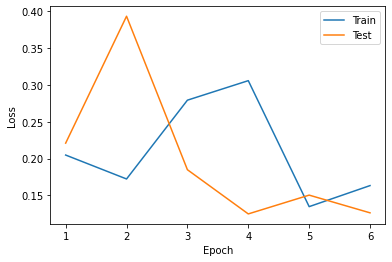

In [ ]:
from matplotlib import pyplot as plt
X = [1, 2, 3, 4, 5, 6]
plt.plot(X, train_loss)
plt.plot(X, test_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(['Train', 'Test'])
plt.show()

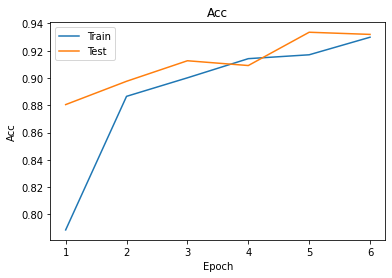

In [ ]:
plt.plot(X, train_acc)
plt.plot(X, test_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Acc")
plt.legend(['Train', 'Test'])
plt.show()

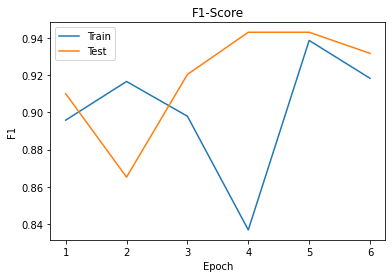

In [ ]:
plt.plot(X, train_f1)
plt.plot(X, test_f1)
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("F1-Score")
plt.legend(['Train', 'Test'])
plt.show()

## Model Viz

In [ ]:
!pip install bertviz

     |████████████████████████████████| 157 kB 4.2 MB/s 


In [ ]:
!pip install ecco

     |████████████████████████████████| 70 kB 5.5 MB/s 
     |████████████████████████████████| 636 kB 44.3 MB/s 
     |████████████████████████████████| 22.3 MB 66.9 MB/s 
     |████████████████████████████████| 4.0 MB 75.2 MB/s 
     |████████████████████████████████| 1.4 MB 74.7 MB/s 
     |████████████████████████████████| 6.6 MB 50.4 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 880 kB 60.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4627a1233847bf50bf3169a96dec80830799a5376beeac287dd82647826ad6b4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    